In [1]:
# Francisco Dominguez Mateos# Francisco Dominguez Mateos
# Kernel dml
#24/03/2021 Some tuning and this works
# Initial code and auxiliar functions. Don't pay attention to this
# 03/12/2021
# Splating lables idea from: https://medium.com/visionwizard/centernet-objects-as-points-a-comprehensive-guide-2ed9993c48bc
# and using FocalLoss  from: https://keras.io/examples/vision/retinanet/
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2
# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [2]:
#! pip install untangle
# The easiest way to parse xml files I have found.
import untangle

In [3]:
# dlib image object detection dataset xml file format
basepath='/home/francisco/datasets/datasets/pictures/indoor_object_detection_dataset/faster_bounding_box_dataset/all'
filename='exit_fire.xml'
obj=untangle.parse(filename)
len(obj.dataset.images.image)

1086

In [20]:
def fillRec(img,x,y,w,h,label):
    img[y:y+h,x:x+w,label]=1

def fillRecSoftMax(img,x,y,w,h,label):
    img[y-1:y+h+2,x-1:x+w+2,    0]=0
    img[y-1:y+h+2,x-1:x+w+2,label]=1
    
def fillRecSoftMax_OLD(img,x,y,w,h,label):
    for i in range(w+1):
        for j in range(h+1):
            nx=x+i
            if nx>=img.shape[1]: nx=img.shape[1]-1
            if nx<0: nx=0
            ny=y+j
            if ny>=img.shape[0]: ny=img.shape[0]-1
            if ny<0: ny=0
            img[ny,nx,0]=0
            img[ny,nx,label]=1
            
def setCenter(img,top,left,width,height):
    center_x=left+width//2
    center_y=top +height//2
    y[center_y,center_x,0]=1

def buildEllipse(im,top,left,width,height,scale=2):
    img=np.zeros((im.shape[0],im.shape[1],1))
    center_x=left+width//2
    center_y=top+height//2
    widthS =width//scale
    heightS=height//scale
    widthS2 =widthS//2
    heightS2=widthS//2
    leftN,topN=center_x-widthS2,center_y-heightS2
    print(topN,leftN,widthS,heightS)
    #image = cv2.ellipse(image, center_coordinates, axesLength, angle, startAngle, endAngle, color, thickness)
    cv2.ellipse(img,(topN,leftN),(widthS,heightS),0,0,360,1,-1)
    return img
    
def setCenterSplat(img,top,left,width,height):
    img_msk=buildEllipse(img,top,left,width,height)
    print(img.shape,img_msk.shape)
    blur = cv2.GaussianBlur(img_msk,(51,51),0)
    print(blur.shape)
    return blur
    
def setBlackBackground(im):
    img=im.copy()
    img[:,:,0]=1
    return img
                
def getLabel(box):
    l=b.label.cdata
    if l=="fireextinguisher":
        return 1
    if l=="exit":
        return 2
    return 0
    
def plt_img(imi,imo):
    #plt.imshow(imi.reshape(height_i,width_i,3))
    plt.imshow(imi)
    width_i =imi.shape[1]
    height_i=imi.shape[0]
    #plt.show()
    #img_np=imo.reshape(height_o,width_o,3)
    img_np=imo #.reshape(height_o,width_o,3)
    img=cv2.resize(img_np,(width_i,height_i))
    #plt.imshow(img,cmap='cool',alpha=0.25)
    plt.imshow(setBlackBackground(img),alpha=0.5)


28 153 5 20
(256, 256) (256, 256, 1)
(256, 256)
(256, 256)
1.0
(256, 256, 3)


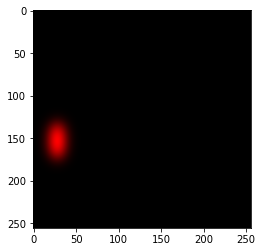

In [22]:
img=np.zeros((256,256))
img_msk=setCenterSplat(img,10,150,10,40)
img_msk=img_msk/np.max(img_msk)
print(img_msk.shape)
print(np.max(img_msk))
img_o=np.zeros((img.shape[0],img.shape[1],3))
img_o[:,:,0]=img_msk
print(img_o.shape)
plt.imshow(img_o)
plt.show()


In [5]:
images=[]
labels=[]
scale=4
reduction=2
classes=3 # exit, fireextinguisher, none

In [6]:
for i in obj.dataset.images.image[:]:
    imgfile=os.path.join(basepath,i['file'])
    #print(imgfile)
    img=cv2.imread(imgfile)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    # resize and 
    # normalize very important!!
    img=img/255.0
    img=cv2.resize(img, (img.shape[1]//scale, img.shape[0]//scale))
    #print(i['file'],'\t',img.shape)
    height_i=img.shape[0]
    width_i =img.shape[1]
    height_o=height_i//reduction
    width_o =width_i //reduction
    y=np.zeros((height_o,width_o,classes))
    fillRecSoftMax(y,0,0,width_o,height_o,0)
    for b in i.box:
        top   =int(b['top'   ])//scale//reduction
        left  =int(b['left'  ])//scale//reduction
        width =int(b['width' ])//scale//reduction
        height=int(b['height'])//scale//reduction
        label=getLabel(b)
        
        #setCenter(y,top,left,width,height)
        fillRecSoftMax(y,left,top,width,height,label)
        #print("  ",b.label.cdata,"\t->\t[",top,",",left,",",width,",",height,"]")
    images.append(img)
    labels.append(y)

In [7]:
N_test=20
images_np=np.array(images)
y_train=np.array(labels[:-N_test])
y_test =np.array(labels[:N_test])
print(images_np.shape)
x_train=images_np[:-N_test]
x_test =images_np[:N_test]
idx=random.randint(0,y_train.shape[0])
print(x_train[idx].shape)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(np.min(y_train),np.max(y_train))

(1086, 180, 320, 3)
(180, 320, 3)
(1066, 180, 320, 3)
(1066, 90, 160, 3)
(20, 180, 320, 3)
(20, 90, 160, 3)
0.0 1.0


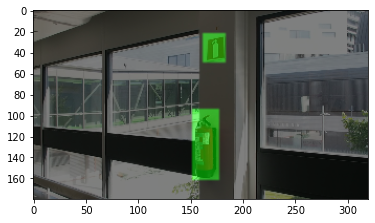

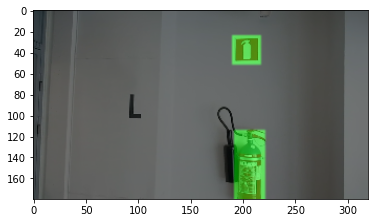

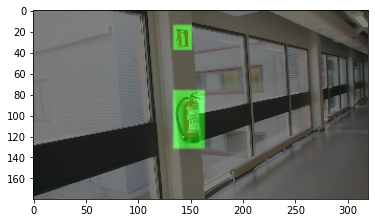

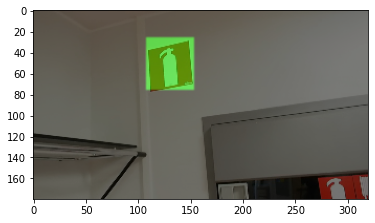

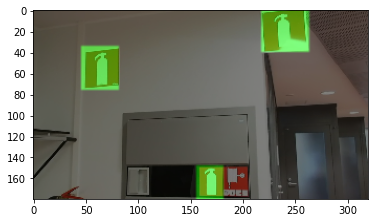

In [8]:
for i in range(5):
    idx=random.randint(0,y_train.shape[0])
    plt.figure()
    plt_img(x_train[idx],y_train[idx])
plt.show()

In [9]:
import tensorflow.keras
from tensorflow.keras.models import Model,Sequential,load_model
from tensorflow.keras.layers import Input,Dense, Dropout,Flatten, LeakyReLU, concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation, Conv2DTranspose
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
import tensorflow as tf
print("tf=   ",tf.__version__)
print("keras=",tf.keras.__version__)

tf=    2.4.1
keras= 2.4.0


In [10]:
#03/12/2021 from: https://keras.io/examples/vision/retinanet/
class FocalLoss(tf.losses.Loss):
    """Implements Focal loss"""

    def __init__(self, alpha=0.25, gamma=2.0):
        super(FocalLoss, self).__init__(
            reduction="none", name="FocalLoss"
        )
        self._alpha = alpha
        self._gamma = gamma
    # y_pred seem to be logits!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    # lost seem to be sigmoid not softmax!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    def call(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=y_true, logits=y_pred
        )
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt    = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1)

In [11]:
def image_softmax(input):
    label_dim = -1
    d = K.exp(input - K.max(input, axis=label_dim, keepdims=True))
    return d / K.sum(d, axis=label_dim, keepdims=True)

__EPS = 1e-5
def image_categorical_crossentropy(y_true, y_pred):
    y_pred = K.clip(y_pred, __EPS, 1 - __EPS)
    return -K.mean(y_true * K.log(y_pred) + (1 - y_true) * K.log(1 - y_pred))

In [12]:
#input_shape=(360,640,3)
# Dynamic Imput size
input_shape=(int(360/2),int(640/2),3)
#input_shape=(None,None,3)

input= Input(input_shape)
x=input
# Without BatchNormalization the model doesn't seem to learn
# (11/04/2019) actually I hadn't normalized the color images just I had to divide by 255
# (11/04/2019) with dropouts and without BatchNorm learn but slowly
c1 = Conv2D(32, 5,padding='same')(x)
c1 = BatchNormalization()(c1)
c1 = LeakyReLU()(c1)
p1 = MaxPooling2D(pool_size=(2, 2))(c1)

c2 = Conv2D(64, 3,padding='same')(p1)
c2 = BatchNormalization()(c2)
c2 = LeakyReLU()(c2)
p2 = MaxPooling2D(pool_size=(2, 2))(c2)

#c3 = Conv2D(128, 3,padding='same')(p2)
#c3 = BatchNormalization()(c3)
#c3 = LeakyReLU()(c3)
#p3 = MaxPooling2D(pool_size=(2, 2))(c3)

c5 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c5 = Dropout(0.5) (c5)
c5 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

# receptive field aproximation 8(reduction)x3(convolution size)=24
#model.add(Conv2D(1, 3, 3, activation='sigmoid',border_mode='same'))
# receptive field aproximation 8(reduction)x5(convolution size)=40
# receptive field aproximation 8(reduction)x7(convolution size)=56

u8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u8 = concatenate([u8, c2])
c8 = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same') (u8)
c8 = BatchNormalization()(c8)
c8 = LeakyReLU()(c8)
#c8 = Dropout(0.1) (c8)
c8 = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same') (c8)
c8 = BatchNormalization()(c8)
c8 = LeakyReLU()(c8)

#u9 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c8)
#u9 = concatenate([u9, c2], axis=3)
#c9 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same') (u9)
#c9 = BatchNormalization()(c9)
#c9 = LeakyReLU()(c9)
#c9 = Dropout(0.1) (c9)
#c9 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same') (c9)
#c9 = BatchNormalization()(c9)
#c9 = LeakyReLU()(c9)

# Last layer n filters = n outputs
#x = Conv2D(classes, 1, activation=image_softmax,padding='same')(c9)
#x = Conv2D(classes, 1, activation="softmax",padding='same')(c9)
# no activation since Focal Lost work with logits
x = Conv2D(classes, 1, padding='same')(c8)
model=Model(input,x)

In [13]:
#model.compile(loss=image_categorical_crossentropy,
#              optimizer=Adam(),
#              metrics=['accuracy'])
loss_fn=FocalLoss()
model.compile(loss=loss_fn,
              optimizer=Adam(),
              metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180, 320, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 180, 320, 32) 2432        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 180, 320, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 180, 320, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [14]:
batch_size=20
epochs=40
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_test,y_test),
                    verbose=1)

Epoch 1/40
54/54 [==============================] - 12s 144ms/step - loss: 0.2560 - accuracy: 0.4275 - val_loss: 0.0294 - val_accuracy: 0.0867
Epoch 2/40
54/54 [==============================] - 7s 121ms/step - loss: 0.0315 - accuracy: 0.3453 - val_loss: 0.0270 - val_accuracy: 0.0808
Epoch 3/40
54/54 [==============================] - 7s 122ms/step - loss: 0.0173 - accuracy: 0.3481 - val_loss: 0.0196 - val_accuracy: 0.3771
Epoch 4/40
54/54 [==============================] - 7s 124ms/step - loss: 0.0124 - accuracy: 0.3711 - val_loss: 0.0153 - val_accuracy: 0.9658
Epoch 5/40
54/54 [==============================] - 7s 123ms/step - loss: 0.0103 - accuracy: 0.3651 - val_loss: 0.0127 - val_accuracy: 0.9499
Epoch 6/40
54/54 [==============================] - 7s 124ms/step - loss: 0.0086 - accuracy: 0.3338 - val_loss: 0.0106 - val_accuracy: 0.6864
Epoch 7/40
54/54 [==============================] - 7s 124ms/step - loss: 0.0077 - accuracy: 0.3234 - val_loss: 0.0081 - val_accuracy: 0.9049
Epoch

In [18]:
model.save(os.path.join('./','u-net-focal-loss-exit_fire.h5'))

In [9]:
model = load_model(os.path.join('./','u-net-focal-loss-exit_fire.h5'))

In [15]:
#score = model.evaluate(x_train, y_train, verbose=0)
#print('Train loss:', score[0])
#print('Train accuracy:', score[1])
#score = model.evaluate(x_test, y_test, verbose=0)
#print('Test loss:', score[0])
#print('Test accuracy:', score[1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


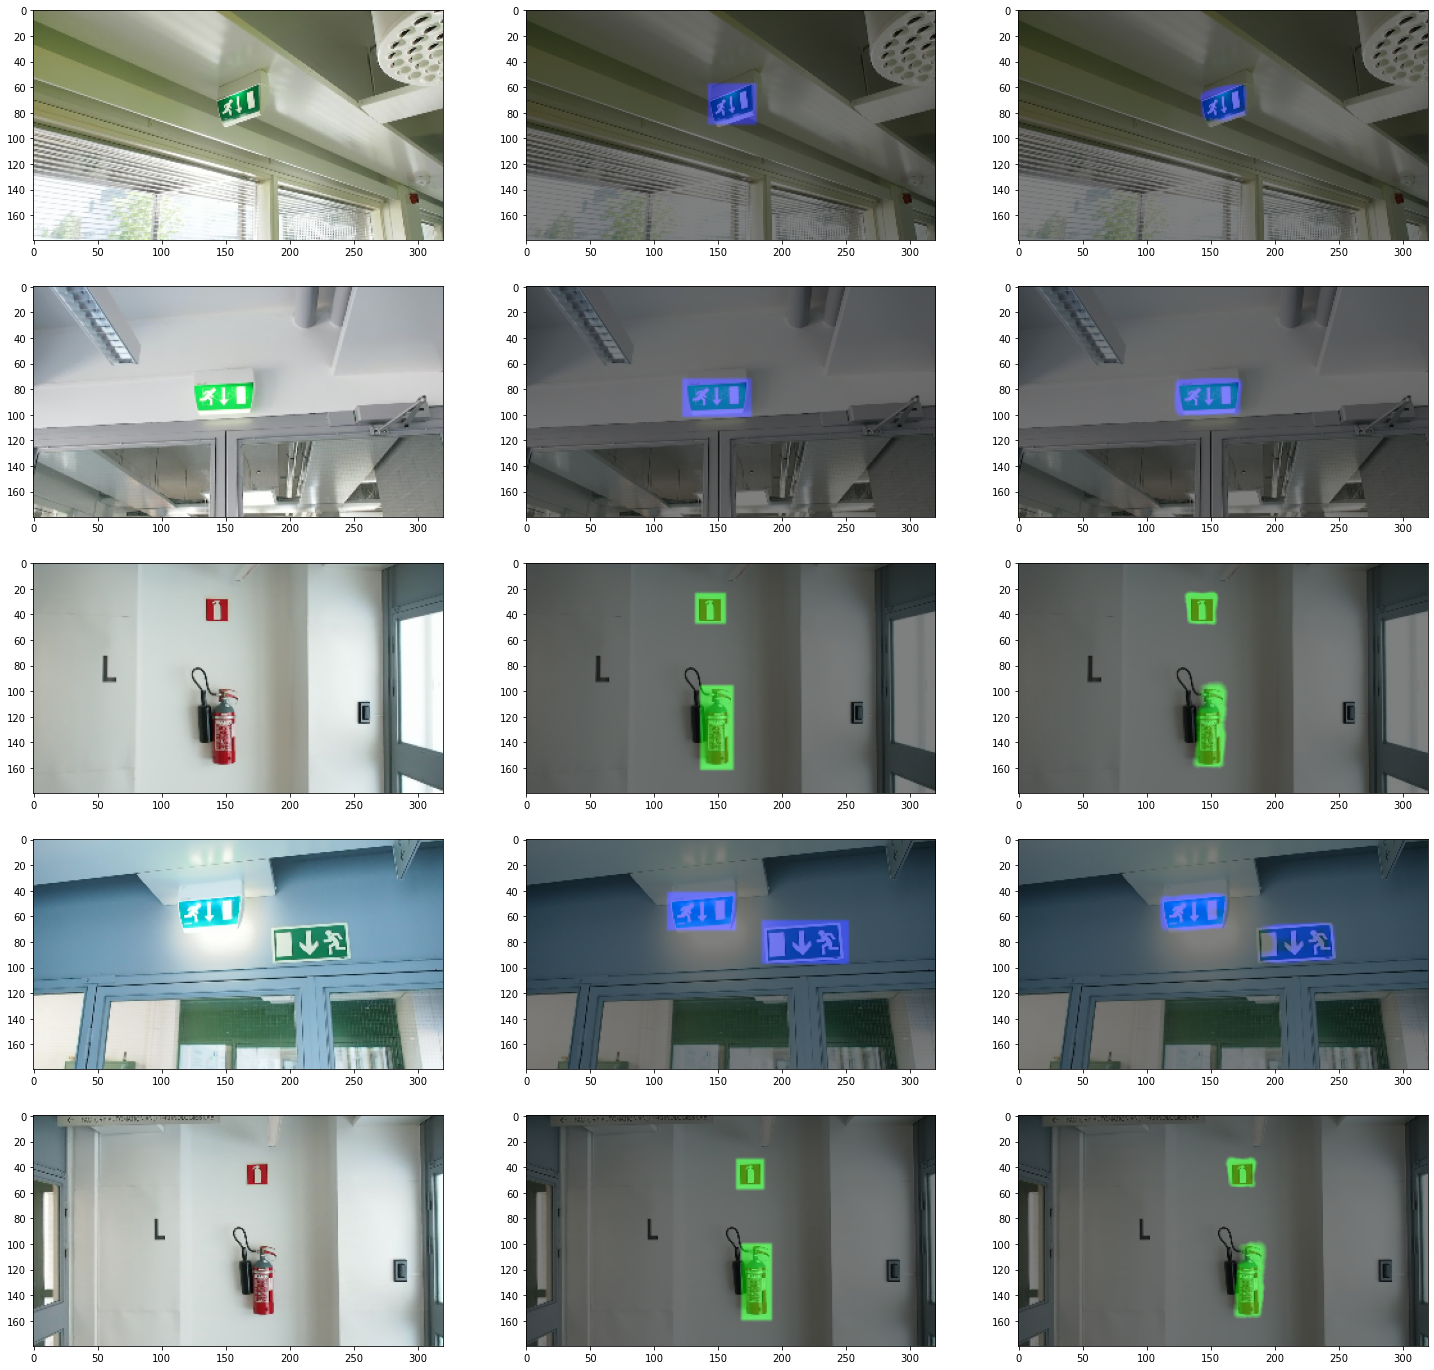

In [15]:
plt.figure(1,figsize=(25,50))
y_pred=model.predict(x_train[:50])
y_dif=np.abs(y_pred-y_train[:50])
for i in range(5):
    idx=random.randint(0,y_pred.shape[0])
    #print(np.max(y_pred[idx]))
    #print(np.sum(y_dif[idx]/(height_o*width_o)))
    plt.subplot(10, 3, i*3+1)
    plt.imshow(x_train[idx].reshape(height_i,width_i,3))
    #plt.show()
    plt.subplot(10, 3, i*3+2)
    #plt.imshow(x_train[idx].reshape(height_i,width_i,3))
    #img_np=setBlackBackground(y_train[idx].reshape(height_o,width_o,3))
    #img=cv2.resize(img_np,(width_i,height_i))
    #plt.imshow(setBlackBackground(img),alpha=0.5)
    plt_img(x_train[idx],y_train[idx])
    #plt.show()
    plt.subplot(10, 3, i*3+3)
    #plt.imshow(setBlackBackground(y_pred[idx].reshape(height_o,width_o,3)))
    plt_img(x_train[idx],y_pred[idx])
    #plt.show()
    #plt.imshow(y_dif[idx].reshape(height_o,width_o),cmap="gray_r")
plt.show()

In [16]:
print("TEST")
print(x_test.shape)
y_predf=model.predict(x_test)
y_pred=y_predf>0.5
y_dif=np.abs(y_pred-y_test)

TEST
(20, 180, 320, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


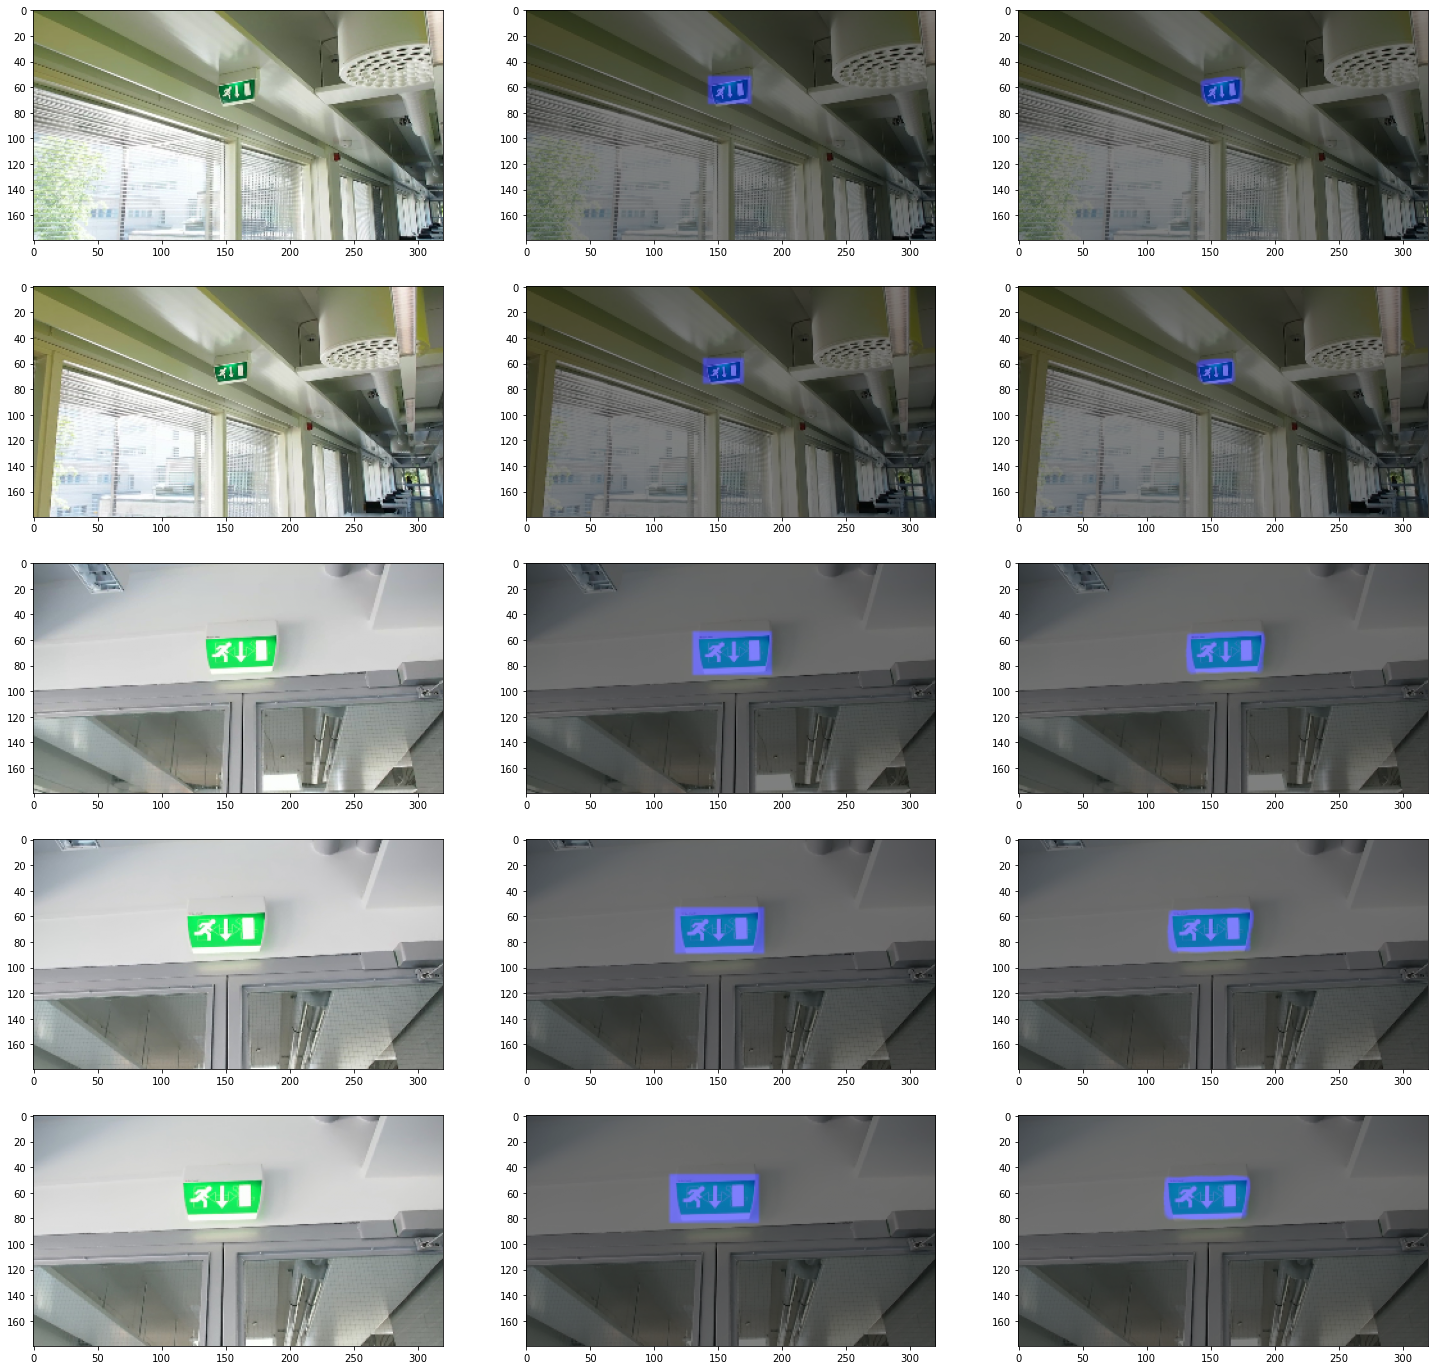

In [17]:
plt.figure(1,figsize=(25,50))
for i in range(5):
    idx=random.randint(0,x_test.shape[0]-1)
    #print(np.max(y_predf[idx]))
    #print(np.sum(y_dif[idx]/(height_o*width_o)))
    plt.subplot(10, 3, i*3+1)
    plt.imshow(x_test[idx].reshape(height_i,width_i,3))
    #plt.show()
    plt.subplot(10, 3, i*3+2)
    plt_img(x_test[idx],y_test[idx])
    #plt.show()
    plt.subplot(10, 3, i*3+3)
    plt_img(x_test[idx],y_predf[idx])
plt.show()

/home/francisco/datasets/datasets/pictures/indoor_object_detection_dataset/faster_bounding_box_dataset/all/frame_s1_119.jpg
(360, 640, 3)


InvalidArgumentError:  Conv2DSlowBackpropInput: Size of out_backprop doesn't match computed: actual = 90, computed = 45 spatial_dim: 2 input: 90 filter: 2 output: 90 stride: 2 dilation: 1
	 [[node model/conv2d_transpose/conv2d_transpose (defined at <ipython-input-19-8a8223f9f0e3>:15) ]] [Op:__inference_predict_function_7421]

Function call stack:
predict_function


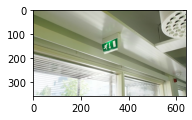

In [20]:
idx=random.randint(0,x_test.shape[0])
i=obj.dataset.images.image[idx]
imgfile=os.path.join(basepath,i['file'])
print(imgfile)
img=cv2.imread(imgfile)
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)/255
img=cv2.resize(img,(320*2,180*2))
#img=cv2.resize(img,(720,512))
nf=3
plt.figure(1,figsize=(nf*2,nf*4))
for i in range(0,nf):
    print(img.shape)
    plt.subplot(nf, 2, i*2+1)
    plt.imshow(img)
    y_predf=model.predict(img.reshape(1,img.shape[0],img.shape[1],img.shape[2]))
    #print(y_predf.shape)
    plt.subplot(nf, 2, i*2+2)
    plt_img(img,y_predf[0])
    sx=int(img.shape[1]*0.5)
    sy=int(img.shape[0]*0.5)
    print(sx,sy)
    if sx%2==1: 
        sx-=1
    if sy%2==1: 
        sy-=1
    print(sx,sy)
    img=cv2.resize(img,(sx,sy))
plt.show()

In [26]:
y_predf=model.predict(img.reshape(1,img.shape[0],img.shape[1],img.shape[2]))
print(img.shape)
print(y_predf.shape)

(32, 64, 3)
(1, 32, 64, 3)


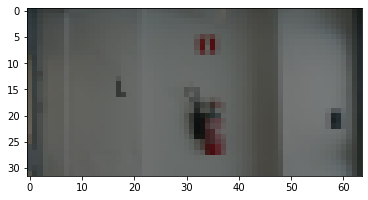

In [16]:
#plt.imshow(y_predf[0].reshape(y_predf.shape[1],y_predf.shape[2],3))
plt_img(img,y_predf[0])

plt.show()